In [1]:
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from accelerate import Accelerator, notebook_launcher
from transformers import AutoModelForSequenceClassification, RobertaForSequenceClassification, AutoTokenizer, get_scheduler, AutoModel
from torch.optim import AdamW
from accelerate.utils import set_seed
import torch
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('/kaggle/input/balance-gold-dataset/balance_train.csv', sep=',')

In [3]:
test = pd.read_csv('/kaggle/input/balance-gold-dataset/balance_test.csv', sep=',')

In [4]:
train.head()

,BID_PRICE,CONTENT,DATE,PRICE,TIME,TITLE,labels
0,66.50,"Lợi suất trái phiếu toàn cầu đang tăng lên, đi...",24/06/2023,67.10,08:30,Giá vàng hôm nay 24/6: Vọt lên cao rồi cắm đầu...,increase
1,67.65,Tài khoản không đủ để thực hiện chức năng này....,14/07/2022,68.25,09:00,Giá vàng hôm nay 14/7: Vàng trong nước tăng ng...,increase
2,56.75,Giá vàng hôm nay ngày 12/7/2021 biến động từ g...,12/07/2021,57.50,08:55,Giá vàng hôm nay ngày 12/7/2021: biến động nhẹ...,decrease
3,68.20,"Hôm qua, thị trường nhận thông tin về báo cáo ...",05/10/2023,68.90,09:20,Giá vàng hôm nay 5/10: Chuyên gia dự đoán lạc ...,decrease
4,74.30,Giá vàng bật tăng khi căng thẳng quân sự leo t...,30/01/2024,76.80,08:55,"Giá vàng hôm nay 30/1: Nhiều yếu tố hỗ trợ, và...",increase


In [5]:
test.head()

,BID_PRICE,CONTENT,DATE,PRICE,TIME,TITLE,labels
0,67.85,. Sự tin tưởng của khu vực kinh doanh vào một ...,25/06/2022,68.65,09:45,"Giá vàng hôm nay 25/6: ""Hụt hơi"" phiên cuối tu...",decrease
1,82.80,Xu hướng mua ròng vàng miếng của các quốc gia ...,10/04/2024,84.80,08:20,"Giá vàng hôm nay 10/4: Sau ""cơn điên"" tăng giá...",increase
2,66.45,Mặc dù tâm lý lạc quan đã quay trở lại nhưng h...,10/07/2023,67.05,08:30,"Giá vàng hôm nay 10/7: Vàng đi ngang, giới đầu...",decrease
3,56.35,Giá vàng hôm nay ngày 5/1/2021 tăng từ 50.000 ...,05/01/2021,56.90,10:20,Giá vàng hôm nay ngày 5/1/2021: vàng tiếp tục ...,increase
4,68.80,. Giá vàng tiếp đà tăng khi thị trường tài chí...,09/06/2022,69.70,08:30,"Giá vàng hôm nay 9/6: Được hỗ trợ mạnh, vàng p...",increase


In [6]:
def get_config():
    config = {'batch_size': 16,
              'model_name': 'uitnlp/visobert',
              'lr': 10 ** -5,
              'num_labels': 2,
              'epochs': 5,
              'num_warmup_steps': 0,
              'seed': 42, 
              'max_length': 256,
              'eos': '[SEP]'
              
    }
    return config 

In [7]:
config = get_config()

### Creating dataset

In [8]:
class get_dataset(Dataset):
    def __init__(self, df: pd.DataFrame) -> None:
        super().__init__()
        self.titles = df['TITLE'].values
        self.content = df['CONTENT'].values
        self.labels = df['labels'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        title = self.titles[idx]
        content = self.content[idx]
        if self.labels[idx] == "increase":
            label = 1
        elif self.labels[idx] == "decrease":
            label = 0
        input_data = title + '[SEP]' + content

        return input_data, label

In [9]:
train_dataset = get_dataset(df=train)
test_dataset  = get_dataset(df=test)

In [10]:
train_dataset[226]

('Giá vàng ngày 6/8/2020: sắp chạm ngưỡng 60 triệu[SEP]Giá vàng lúc 9h10 ngày 6/8/2020 sắp chạm ngưỡng 60 triệu với mức tăng từ 350.000 đến 800.000 đồng/lượng. Biên độ chênh lệch giá mua vào bán ra từ 1.050.000 đến 1.270.000 đồng/lượng.\r\nGiá vàng trong nước\r\n\r\n\r\nGiá vàng tại SJC mua vào ở mức 58.600.000/lượng (tăng 700.000/lượng), bán ra ở mức 59.870.000/lượng (tăng 750.000/lượng). Giá chênh mua bán là 1.270.000/lượng\r\nGiá vàng tại hệ thống Bảo Tín Minh Châu mua vào bán ra lần lượt là 58.400.000 và 59.450.000/lượng, tăng 350.000/lượng chiều mua và 450.000/lượng chiều bán. Mức chênh lệch mua vào bán ra là 1.050.000/lượng\r\nTại hệ thống PNJ, giá vàng tăng 500.000/lượng chiều mua lên mức 58.500.000/lượng, chiều bán tăng 800.000/lượng lên mức 59.600.000/lượng. Biên độ chênh lệch mua bán là 1.100.000/lượng\r\nGiá vàng tại Phú Quý niêm yết ở mức 58.300.000/lượng mua vào và 59.500.000/lượng bán ra, tăng 400.000/lượng chiều mua và 600.000/lượng chiều bán. Chênh lệch mua vào bán ra l

In [11]:
def create_dataloader(dataset: Dataset, config: dict, is_train: bool) -> DataLoader:

    return DataLoader(dataset=dataset, batch_size=config['batch_size'], shuffle=is_train, drop_last=is_train) 

In [12]:
train_loader = create_dataloader(train_dataset, config, True)
test_loader  = create_dataloader(test_dataset, config, False)

### Training

In [13]:
config['model_name']

'uitnlp/visobert'

In [14]:
tokenizer = AutoTokenizer.from_pretrained(config['model_name'])

### Training

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# create model
model = RobertaForSequenceClassification.from_pretrained(config['model_name'], num_labels=config['num_labels'])

# create optimizer
optimizer = AdamW(params=model.parameters(), lr=config['lr'])

train_loader = create_dataloader(train_dataset, config, True)
test_loader = create_dataloader(test_dataset, config, False)

num_training_steps = config['epochs'] * len(train_loader)
# create lr scheduler
lr_scheduler = get_scheduler(
    'cosine', optimizer=optimizer, num_warmup_steps=config['num_warmup_steps'], num_training_steps=num_training_steps
)

# create loss function
loss_fn = torch.nn.CrossEntropyLoss()

model.to(device)
epochs = config['epochs']

# Early stopping parameters
patience = 2
best_eval_loss = float('inf')
early_stopping_counter = 0

You are using a model of type xlm-roberta to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at uitnlp/visobert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# training
print("========== Start training ==========")
for epoch in range(epochs):
    model.train()
    training_loss = 0
    for inputs, labels in train_loader:
        inputs = tokenizer(inputs, return_tensors='pt', max_length=config['max_length'], padding='longest', truncation=True).to(device)
        labels = labels.to(device)

        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        training_loss += loss.item()

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

    training_loss /= len(train_loader)

    # testing
    eval_loss = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = tokenizer(inputs, return_tensors='pt', max_length=config['max_length'], padding='longest', truncation=True).to(device)
            labels = labels.to(device)

            outputs = model(**inputs, labels=labels)
            loss = outputs.loss
            eval_loss += loss.item()

    eval_loss /= len(test_loader)
    print(f"Epoch {epoch + 1}, Training loss: {training_loss:.4f}, Eval loss: {eval_loss:.4f}")

    # Check for early stopping
    if eval_loss < best_eval_loss:
        best_eval_loss = eval_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print("Early stopping triggered")
        break

print("========== End training ==========")

========== Start training ==========
Epoch 1, Training loss: 0.7132, Eval loss: 0.6922
Epoch 2, Training loss: 0.6643, Eval loss: 0.6012
Epoch 3, Training loss: 0.5015, Eval loss: 0.3655
Epoch 4, Training loss: 0.3913, Eval loss: 0.3140


### Inference

In [ ]:
preds = []

In [18]:
model.eval()
with torch.no_grad(): 
    for inputs, labels in test_loader:
        inputs = tokenizer(inputs, return_tensors='pt', max_length=config['max_length'], padding='longest', truncation=True).to(device)
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        _, predicted_labels = torch.max(probs, dim=1)
        preds.extend(predicted_labels.detach().cpu().tolist()) 

In [19]:
labels = test['labels'].values
labels = [1 if label == 'increase' else 0 for label in labels]

In [20]:
acc  = accuracy_score(labels, preds)
precision = precision_score(labels, preds)
recall = recall_score(labels, preds)
f1 = f1_score(labels, preds)

In [21]:
print(f"========== Evaluation Metrics ==========")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1 Score  : {f1:.4f}")
print(f"========================================")

========== Evaluation Metrics ==========
Accuracy  : 0.8716
Precision : 0.8372
Recall    : 0.9351
F1 Score  : 0.8834


Confusion metrics

Confusion matrix is: [[57 14]
 [ 5 72]]


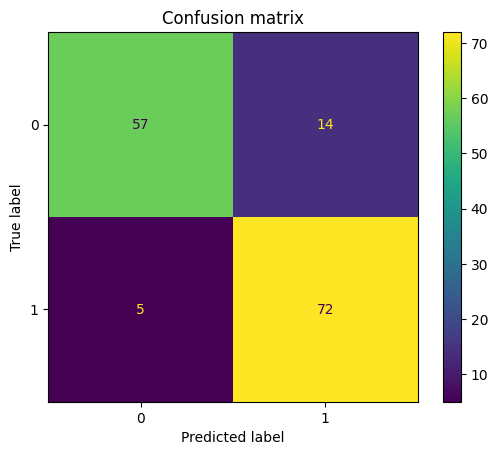

In [22]:
cfn = confusion_matrix(labels, preds)
print(f"Confusion matrix is: {cfn}")
ConfusionMatrixDisplay.from_predictions(labels, preds)
plt.title('Confusion matrix')
plt.show()